In [1]:
import nltk

In [57]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict

import spacy
from nltk.corpus import stopwords

import regex as re
import string
import gensim

In [52]:
from nltk import word_tokenize 
from nltk.util import ngrams

In [8]:
df = pd.read_csv("disastertweets_train.csv")
df.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


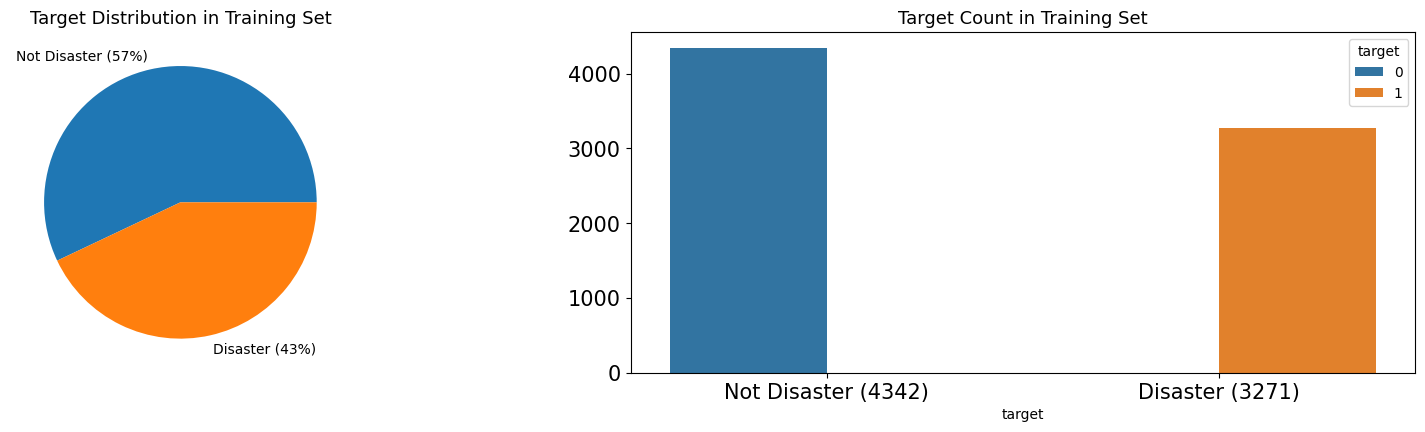

In [14]:
fig, axes = plt.subplots(ncols=2, figsize=(17, 4), dpi=100)
plt.tight_layout()

df.groupby('target').count()['id'].plot(kind='pie', ax=axes[0], labels=['Not Disaster (57%)', 'Disaster (43%)'])
sns.countplot(x=df['target'], hue=df['target'], ax=axes[1])

axes[0].set_ylabel('')
axes[1].set_ylabel('')
axes[1].set_xticklabels(['Not Disaster (4342)', 'Disaster (3271)'])
axes[0].tick_params(axis='x', labelsize=15)
axes[0].tick_params(axis='y', labelsize=15)
axes[1].tick_params(axis='x', labelsize=15)
axes[1].tick_params(axis='y', labelsize=15)

axes[0].set_title('Target Distribution in Training Set', fontsize=13)
axes[1].set_title('Target Count in Training Set', fontsize=13)

plt.show()

In [16]:
def clean_text(text):
    '''Make text lowercase, remove text in square brackets,remove links,remove punctuation
    and remove words containing numbers.'''
    text = str(text).lower()
    text = re.sub('\[.*?\]', '', text)
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub('<.*?>+', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\n', '', text)
    text = re.sub('\w*\d\w*', '', text)
    return text

In [21]:
df['text'] = df['text'].apply(lambda x:clean_text(x))

In [22]:
df.head()

,id,keyword,location,text,target
0,1,NaN,NaN,our deeds are the reason of this earthquake ma...,1
1,4,NaN,NaN,forest fire near la ronge sask canada,1
2,5,NaN,NaN,all residents asked to shelter in place are be...,1
3,6,NaN,NaN,people receive wildfires evacuation orders in...,1
4,7,NaN,NaN,just got sent this photo from ruby alaska as s...,1


In [33]:
df['tokenized'] = np.nan

for i in range(len(df)):
    df['tokenized'][i]= list(gensim.utils.tokenize(df['text'][i]))
    

C:\Users\chinj\AppData\Local\Temp\ipykernel_5368\461379296.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['tokenized'][i]= list(gensim.utils.tokenize(df['text'][i]))
c:\Users\chinj\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


In [35]:
def remove_stopword(x):
    return [y for y in x if y not in stopwords.words('english')]


In [36]:
df['nostopwords_text'] = df['tokenized'].apply(lambda x:remove_stopword(x))

In [37]:
df.head()

,id,keyword,location,text,target,nostopwords_text,tokenized
0,1,NaN,NaN,our deeds are the reason of this earthquake ma...,1,"[deeds, reason, earthquake, may, allah, forgiv...","[our, deeds, are, the, reason, of, this, earth..."
1,4,NaN,NaN,forest fire near la ronge sask canada,1,"[forest, fire, near, la, ronge, sask, canada]","[forest, fire, near, la, ronge, sask, canada]"
2,5,NaN,NaN,all residents asked to shelter in place are be...,1,"[residents, asked, shelter, place, notified, o...","[all, residents, asked, to, shelter, in, place..."
3,6,NaN,NaN,people receive wildfires evacuation orders in...,1,"[people, receive, wildfires, evacuation, order...","[people, receive, wildfires, evacuation, order..."
4,7,NaN,NaN,just got sent this photo from ruby alaska as s...,1,"[got, sent, photo, ruby, alaska, smoke, wildfi...","[just, got, sent, this, photo, from, ruby, ala..."


In [41]:
# Unigrams

disasterwords= []
nondisasterwords = []

for i in range(len(df)):
    for item in df['nostopwords_text'][i]:
        if df['target'][i] == 1:
            disasterwords.append(item)
        else:
            nondisasterwords.append(item)

In [42]:
# Word counts distribution
fdist_dis = nltk.FreqDist(disasterwords)
fdist_nondis = nltk.FreqDist(nondisasterwords)

print("Most common words in disaster tweets:\n", fdist_dis.most_common(10))
print("Most common words in non-disaster tweets:\n", fdist_nondis.most_common(10))

Most common words in disaster tweets:
 [('û', 213), ('fire', 179), ('news', 132), ('via', 121), ('disaster', 116), ('california', 111), ('suicide', 110), ('amp', 106), ('people', 105), ('police', 105)]
Most common words in non-disaster tweets:
 [('like', 252), ('im', 240), ('û', 224), ('amp', 192), ('new', 170), ('get', 162), ('dont', 139), ('one', 127), ('body', 113), ('via', 99)]


In [58]:
def generate_ngrams(text, n_gram=1):
    token = [token for token in text.lower().split(' ') if token != '' if token not in stopwords.words('english')]
    ngrams = zip(*[token[i:] for i in range(n_gram)])
    return [' '.join(ngram) for ngram in ngrams]


# # Unigrams
# disaster_unigrams = defaultdict(int)
# nondisaster_unigrams = defaultdict(int)

# for tweet in df['nostopwords_text']:
#     for word in generate_ngrams(tweet):
#         disaster_unigrams[word] += 1
        
# for tweet in df_train[~DISASTER_TWEETS]['text']:
#     for word in generate_ngrams(tweet):
#         nondisaster_unigrams[word] += 1
        
# df_disaster_unigrams = pd.DataFrame(sorted(disaster_unigrams.items(), key=lambda x: x[1])[::-1])
# df_nondisaster_unigrams = pd.DataFrame(sorted(nondisaster_unigrams.items(), key=lambda x: x[1])[::-1])

# Bigrams
disaster_bigrams = defaultdict(int)
nondisaster_bigrams = defaultdict(int)

for i in range(len(df)):
    if df['target'][i]== 1:
        for word in generate_ngrams(df['text'][i], n_gram=2):
            disaster_bigrams[word] += 1
    else:
        for word in generate_ngrams(df['text'][i], n_gram=2):
            nondisaster_bigrams[word] += 1
        

        
df_disaster_bigrams = pd.DataFrame(sorted(disaster_bigrams.items(), key=lambda x: x[1])[::-1])
df_nondisaster_bigrams = pd.DataFrame(sorted(nondisaster_bigrams.items(), key=lambda x: x[1])[::-1])



In [113]:
df_disaster_bigrams.head(10)

,0,1
0,suicide bomber,59
1,northern california,41
2,oil spill,38
3,burning buildings,34
4,california wildfire,34
5,suicide bombing,33
6,bomber detonated,30
7,homes razed,29
8,detonated bomb,28
9,pkk suicide,28


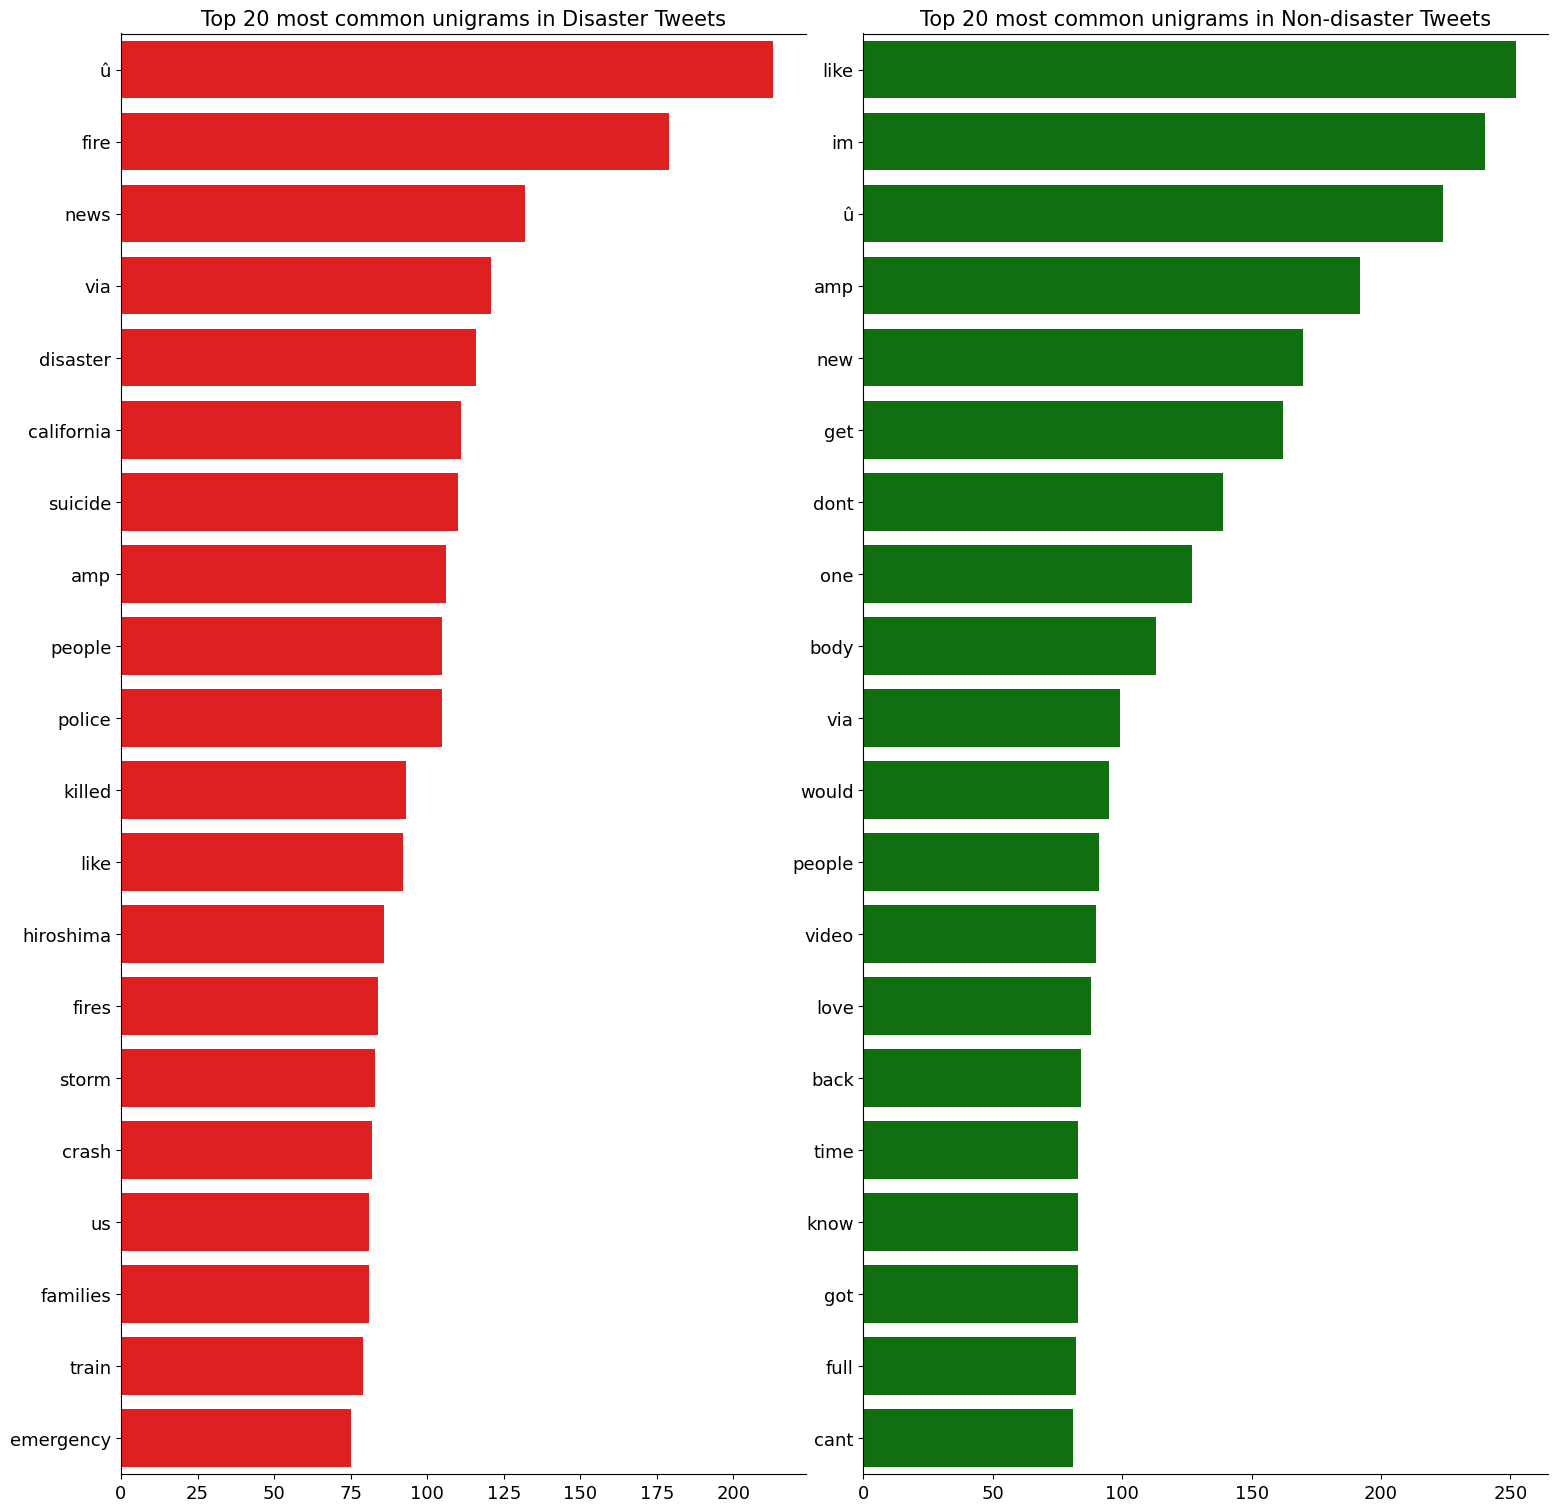

In [102]:
N= 20

fig, axes = plt.subplots(ncols=2, figsize=(15, 15), dpi=100)
plt.tight_layout()

sns.barplot(y=list(dict(fdist_dis.most_common(20)).keys()), x=list(dict(fdist_dis.most_common(20)).values()), ax=axes[0], color='red')
sns.barplot(y=list(dict(fdist_nondis.most_common(20)).keys()), x=list(dict(fdist_nondis.most_common(20)).values()), ax=axes[1], color='green')

for i in range(2):
    axes[i].spines['right'].set_visible(False)
    axes[i].set_xlabel('')
    axes[i].set_ylabel('')
    axes[i].tick_params(axis='x', labelsize=13)
    axes[i].tick_params(axis='y', labelsize=13)

axes[0].set_title(f'Top {N} most common unigrams in Disaster Tweets', fontsize=15)
axes[1].set_title(f'Top {N} most common unigrams in Non-disaster Tweets', fontsize=15)

plt.show()

C:\Users\chinj\AppData\Roaming\Python\Python310\site-packages\IPython\core\pylabtools.py:151: UserWarning: Glyph 137 (\x89) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


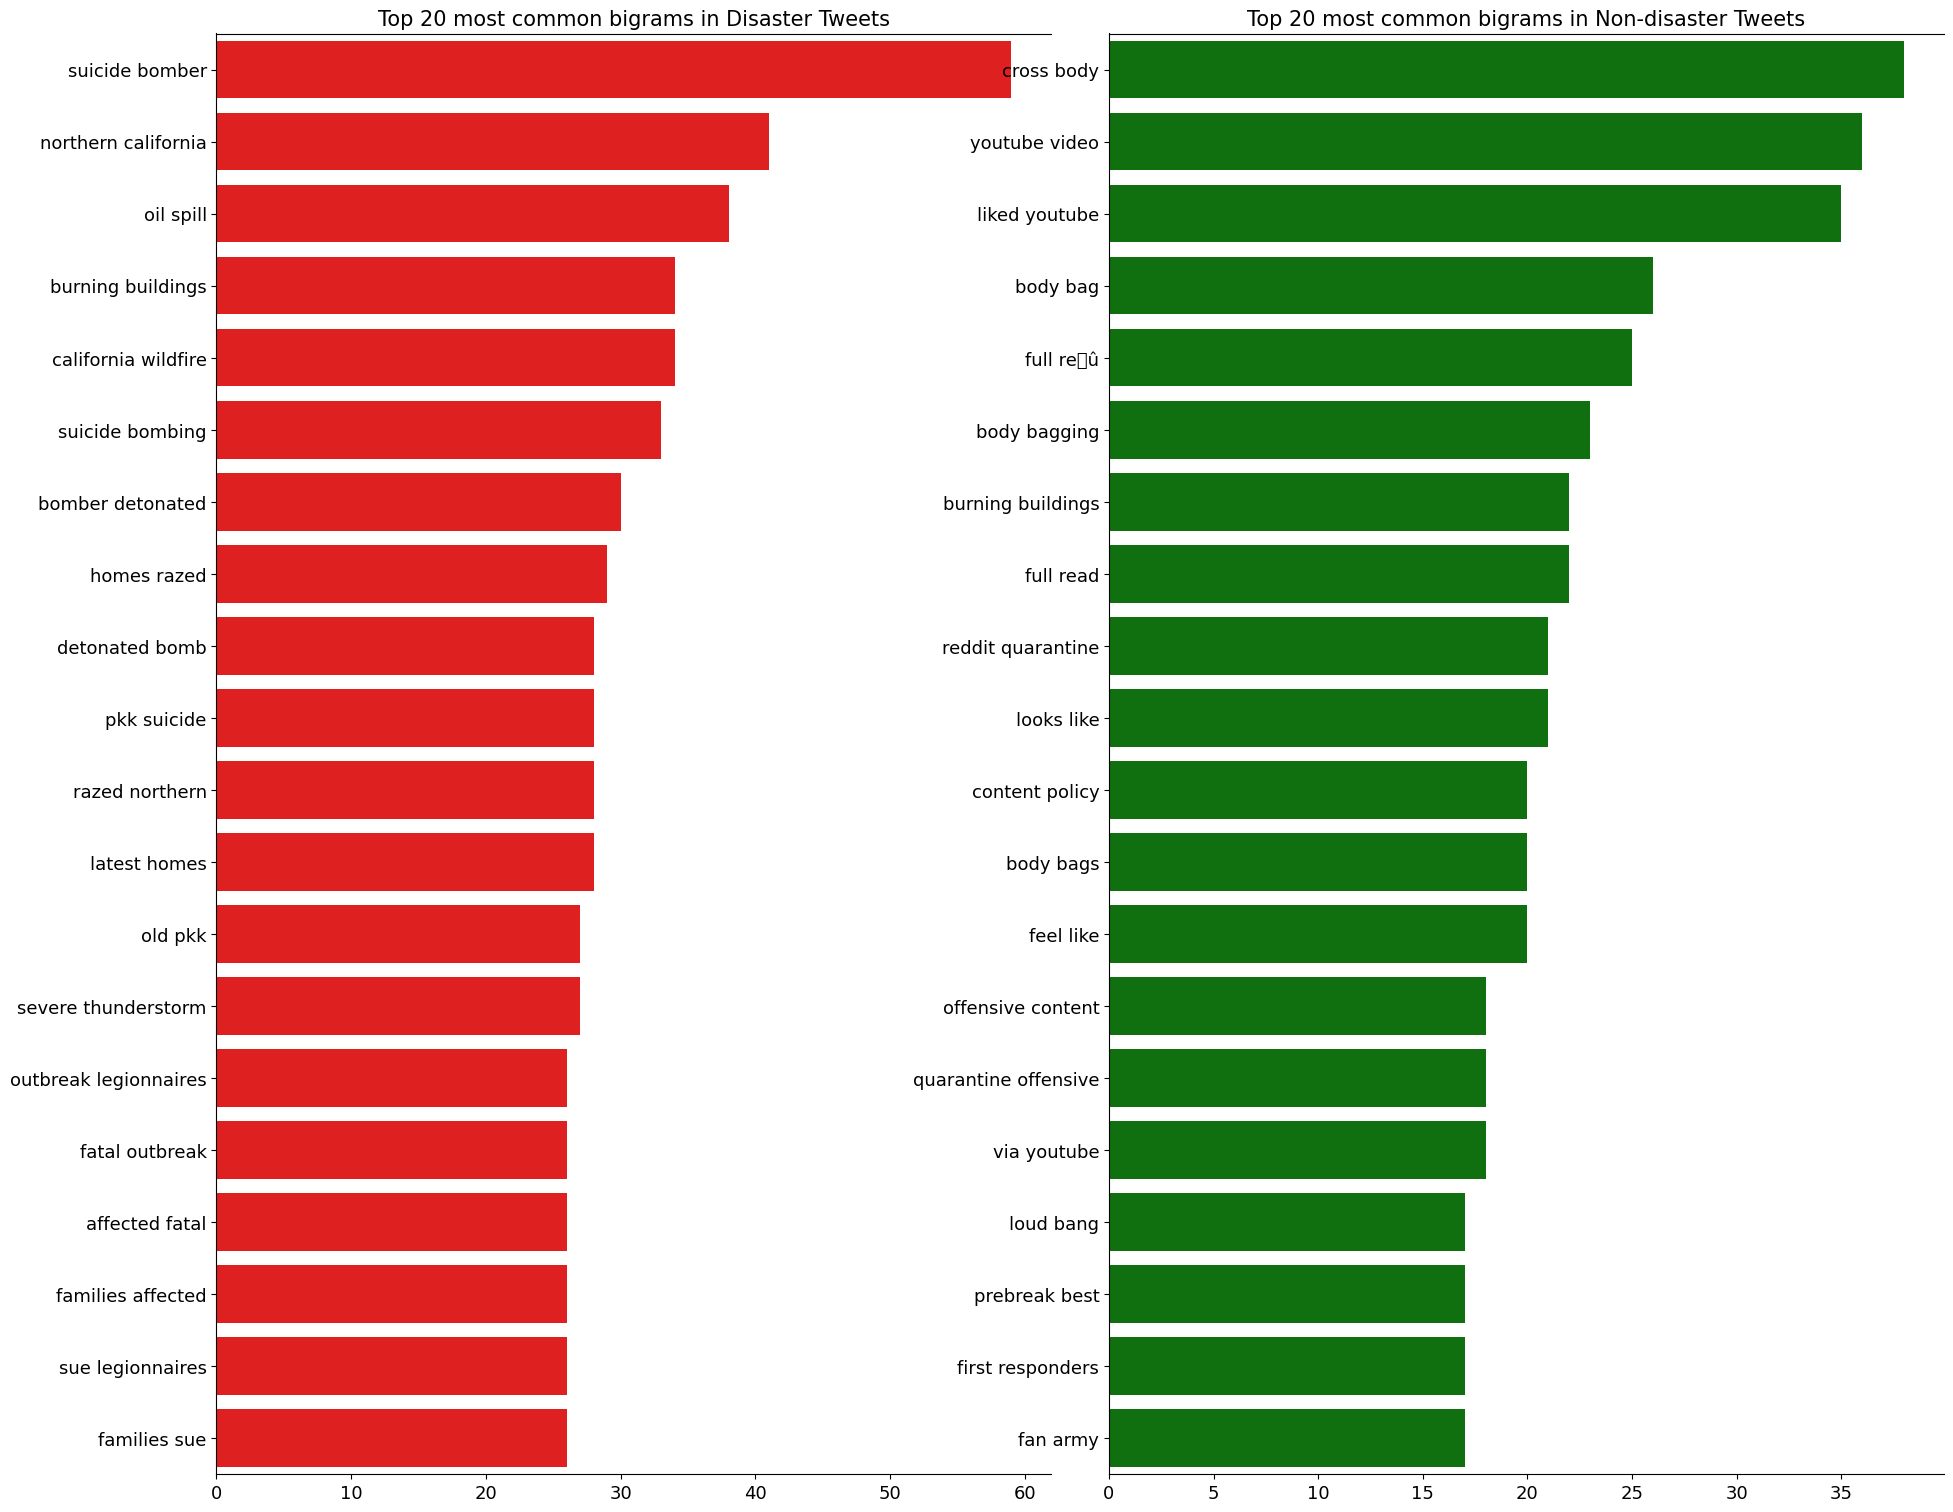

In [105]:
fig, axes = plt.subplots(ncols=2, figsize=(18, 15), dpi=100)
plt.tight_layout()

sns.barplot(y=df_disaster_bigrams[0].values[:N], x=df_disaster_bigrams[1].values[:N], ax=axes[0], color='red')
sns.barplot(y=df_nondisaster_bigrams[0].values[:N], x=df_nondisaster_bigrams[1].values[:N], ax=axes[1], color='green')

for i in range(2):
    axes[i].spines['right'].set_visible(False)
    axes[i].set_xlabel('')
    axes[i].set_ylabel('')
    axes[i].tick_params(axis='x', labelsize=13)
    axes[i].tick_params(axis='y', labelsize=13)

axes[0].set_title(f'Top {N} most common bigrams in Disaster Tweets', fontsize=15)
axes[1].set_title(f'Top {N} most common bigrams in Non-disaster Tweets', fontsize=15)

plt.show()